In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 200
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 10000
LIB_MAXDEPTH  = 5
LIB_MAXLENGTH = 15

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
profiling.enable()
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
profiling.disable()

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         1627214 function calls (1525057 primitive calls) in 2.504 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    2.504    1.252 interactiveshell.py:3472(run_code)
        1    0.000    0.000    2.504    2.504 corrector.py:13(__init__)
        1    0.085    0.085    2.502    2.502 library.py:478(__init__)
        1    0.200    0.200    2.114    2.114 library.py:125(__init__)
        1    0.026    0.026    1.229    1.229 creator.py:124(create_population)
    10000    0.167    0.000    0.965    0.000 creator.py:63(ptc2)
    47007    0.157    0.000    0.511    0.000 creator.py:43(createRandomNonTerminal)
33813/14312    0.054    0.000    0.261    0.000 binop.py:62(simplify)
44127/18905    0.047    0.000    0.250    0.000 unaop.py:53(simplify)
14298/6495    0.025    0.000    0.181    0.000 binop.py:24(__call__)
    92430    0.137    0.000    0.175    0.000 syntax_tree.py:67(__init__)
16631/7496 

In [5]:
n = corrector.symm_n + corrector.asymm_n + corrector.lib_n
print(f"SYMM: {corrector.symm_n/n}")
print(f"ASYMM: {corrector.asymm_n/n}")
print(f"LIB: {corrector.lib_n/n}")

SYMM: 0.0
ASYMM: 0.0
LIB: 1.0


In [6]:
profiling.print_stats()

         1627214 function calls (1525057 primitive calls) in 2.504 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    2.504    1.252 interactiveshell.py:3472(run_code)
        1    0.000    0.000    2.504    2.504 corrector.py:13(__init__)
        1    0.085    0.085    2.502    2.502 library.py:478(__init__)
        1    0.200    0.200    2.114    2.114 library.py:125(__init__)
        1    0.026    0.026    1.229    1.229 creator.py:124(create_population)
    10000    0.167    0.000    0.965    0.000 creator.py:63(ptc2)
    47007    0.157    0.000    0.511    0.000 creator.py:43(createRandomNonTerminal)
33813/14312    0.054    0.000    0.261    0.000 binop.py:62(simplify)
44127/18905    0.047    0.000    0.250    0.000 unaop.py:53(simplify)
14298/6495    0.025    0.000    0.181    0.000 binop.py:24(__call__)
    92430    0.137    0.000    0.175    0.000 syntax_tree.py:67(__init__)
16631/7496 

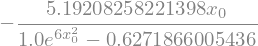

In [7]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [8]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)  #'(sqrt((x2 * ((x1 * x0) * 0.00))) * 0.00)'

{'mse': 0.0015327008818535783,
 'rmse': 0.039149723905202424,
 'r2': 0.9961348953513852}

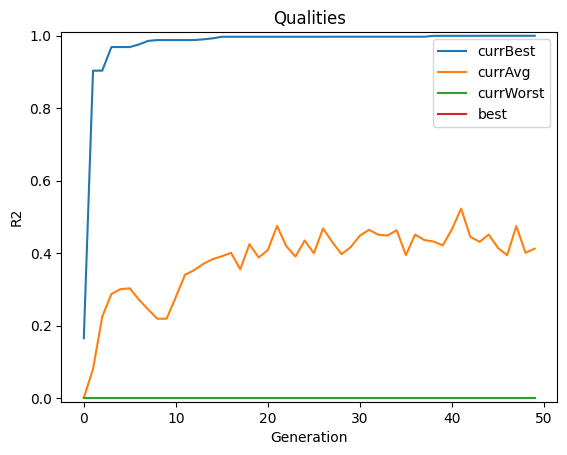

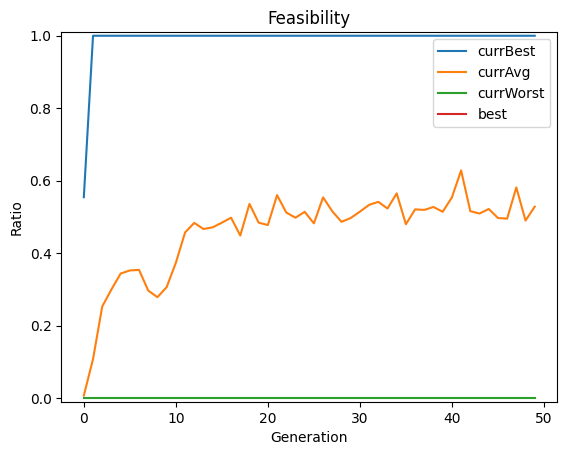

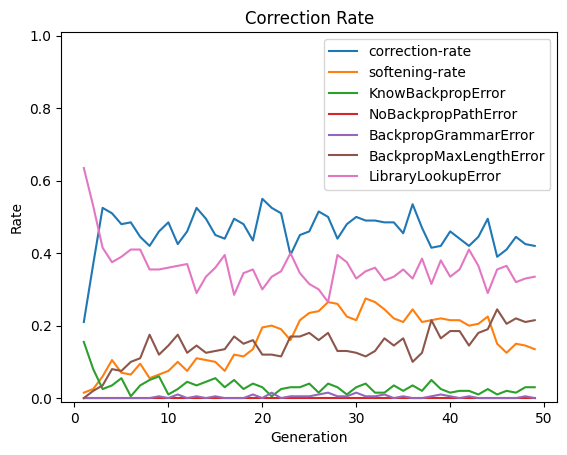

In [9]:
symb_regressor.stats.plot()

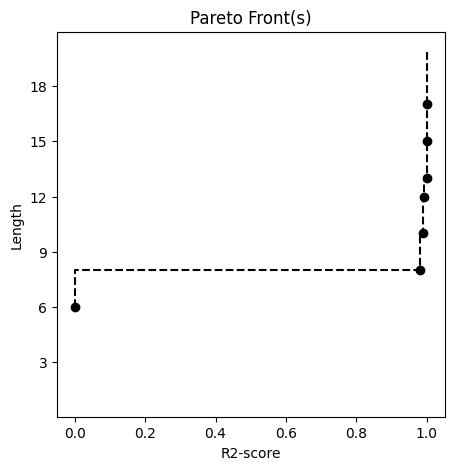

Feasibility Ratio: 1.0
Extent of Convergence: 0.6279430036154291


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((x0 / -1114.39) / square(x0)),0,0.000417,0.000596,6,"(square, /)",2,inf
1,1,((x0 / 0.19) / (exp(x0) - ((exp(x0) + -0.63) +...,0,0.149987,0.999914,17,"(+, exp, cube, square, /)",2,inf
2,2,((x0 / 2.23) / (-0.02 - square(x0))),0,0.588357,0.980595,8,"(square, /)",2,1.352725
3,3,((x0 * 1.07) / (0.94 - square(exp(square(x0))))),0,0.494505,0.989010,10,"(square, exp, /)",2,0.374303
4,4,((x0 / 0.19) / (x0 - ((x0 + -0.63) + cube(squa...,0,0.249978,0.999913,15,"(+, exp, cube, square, /)",2,0.363704
5,5,(x0 / (0.78 - ((-0.51 * square(exp(square(x0))...,0,0.396502,0.991255,12,"(square, exp, /)",2,0.283571
6,6,((x0 / 0.19) / (0.62 - (0.00 + square(cube(exp...,0,0.349946,0.999846,13,"(cube, square, exp, /)",1,0.281392


In [10]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, 0)
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)